## Environment Initialization

In [1]:
import pandas as pd
import spacy

# Load the dataset
df = pd.read_csv("./job_descriptions.csv", nrows=50000)

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

## Data Preparation

In [3]:
import data_cleaning as dc

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MultiLabelBinarizer

# Clean the text data
lemmatizer = WordNetLemmatizer()
df['Job Description'] = df['Job Description'].apply(lambda x: dc.preprocess_document(x, lemmatizer))
df['skills'] = df['skills'].apply(dc.preprocess_skills)

# Prepare the features
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['Job Description'])

# Prepare the targets
df['skills'] = df['skills'].apply(dc.preprocess_skills)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['skills'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Tuning

In [30]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import matplotlib.pyplot as plt

# # Find optimal number of clusters using silhouette score
# potential_k = [2, 5, 10, 25, 50, 100, 250, 500]
# silhouette_scores = []
# optimal_k = (0, 0)
# for k in potential_k:  # silhouette score cannot be computed with a single cluster
#     # Instantiate and fit KMeans
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     cluster_labels = kmeans.fit_predict(X_train)
    
#     # Compute the silhouette score
#     score = silhouette_score(X_train, cluster_labels)
#     silhouette_scores.append(score)
    
#     # Update optimal_k
#     if score > optimal_k[1]:
#         optimal_k = (k, score)

/Users/seby/Desktop/School/2024_Spring/cs4120/group_project/JobAssist/myenv/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (376) found smaller than n_clusters (500). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


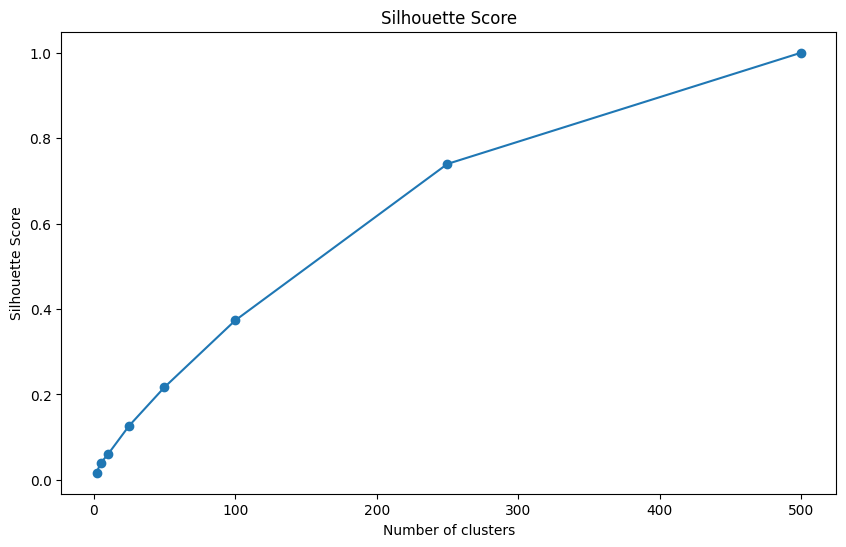

Optimal number of clusters: 500 with a silhouette score of 0.9999999976855269


In [31]:
# plt.figure(figsize=(10, 6))
# plt.plot(potential_k, silhouette_scores, marker='o')
# plt.title('Silhouette Score')
# plt.xlabel('Number of clusters')
# plt.ylabel('Silhouette Score')
# plt.show()

# print(f"Optimal number of clusters: {optimal_k[0]} with a silhouette score of {optimal_k[1]}")

## Model Creation & Evaluation

In [41]:
from sklearn.cluster import KMeans
import numpy as np

# Create model with optimal number of clusters
optimal_clusters = 100
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=100, random_state=42)

In [42]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Predict clusters for both training and testing sets
train_preds = kmeans.predict(X_train)
test_preds = kmeans.predict(X_test)

# Evaluate the model
silhouette = silhouette_score(X_test, test_preds)

# Adjusted Rand Index (ARI) comparing the true labels and predicted cluster labels
ari_train = adjusted_rand_score(y_train, train_preds)
ari_test = adjusted_rand_score(y_test, test_preds)

silhouette, ari_train, ari_test

(0.3648706424485096, 0.4368827944750032, 0.42784699377017776)

## Custom Examples

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_skills(job_description, tfidf_vectorizer, model, skill_amt=5):
    """Get the top n skills for a job description.

    Args:
        job_description (str): The job description to analyze.
        tfidf_vectorizer (TfidfVectorizer): The TfidfVectorizer used to transform the job description.
        model (Model): The model used to predict the skills.
        skill_amt (int): The number of skills to return.
    """
    # Preprocess the inputted description
    job_description = preprocess_text(job_description, STOP_WORDS)
    input_vector = tfidf_vectorizer.transform([job_description])
    
    # Predict the cluster for the new job description
    predicted_cluster = model.predict(input_vector)[0]
    
    # Filter the dataframe for job descriptions in the predicted cluster
    cluster_job_descriptions = df[df['cluster_label'] == predicted_cluster]
    
    # Now, instead of calculating cosine similarity across all job descriptions,
    # we limit our scope to those within the same cluster
    similarity_scores = cosine_similarity(input_vector, tfidf_vectorizer.transform(cluster_job_descriptions['Job Description']))
    
    # Extract indices of top similar job descriptions within the cluster
    top_similar_indices_within_cluster = np.argsort(similarity_scores[0])[-skill_amt:][::-1]
    
    # Initialize a set to hold unique recommended skills
    recommended_skills = set()
    for idx in top_similar_indices_within_cluster:
        # Note: Adjust indexing if necessary to align with your dataframe's indexing
        skills = preprocess_skills(cluster_job_descriptions.iloc[idx]['skills'])
        for skill in skills:
            recommended_skills.add(skill)
    
    return recommended_skills

In [46]:
# Test the recommendation model (please for now excuse the code duplication loll)
job_description1 = "Seeking an experienced financial accountant to join our auditing department."
job_description2 = "Urgently hiring a educational specialist in early-childhood development and special education curriculums."
job_description3 = "Looking for a skilled backend software developer with experience in networks and database design, and object-oriented programming in Java, Python, etc."

recommended_skills1 = get_skills(job_description1, tfidf_vectorizer, kmeans_model)
recommended_skills2 = get_skills(job_description2, tfidf_vectorizer, kmeans_model)
recommended_skills3 = get_skills(job_description3, tfidf_vectorizer, kmeans_model)

print("Recommended Skills:", recommended_skills1)
print("Recommended Skills:", recommended_skills2)
print("Recommended Skills:", recommended_skills3)

Recommended Skills: {'Team leadership', 'Financial planning', 'Wealth management', 'Investment strategies', 'Client advisory skills'}
Recommended Skills: {'Artistic expertise', 'Teacher training', 'Communication skills', 'Program development', 'Art education curriculum'}
Recommended Skills: {'APIs', 'Database integration', 'Java', 'Backend development', 'EE', 'Version control', 'Performance optimization', 'RESTful'}
